In [1]:
import scipy
import numpy as np
import matplotlib.pyplot as plt

### The goal is to demonstrate how variational/weak formulation can be used to solve an elliptic PDE.
We use the following example:
$$-u''(x) = f(x), \qquad u(0) = u(1) = 0$$
on the domain $[0,1]$.

In [2]:
Lx = 0 # boundary 
Rx = 1 # boundary
x_list = np.linspace(Lx, Rx, 100)

def exact_u(f, x):
    """
        The exact solution for 1D case.
        
        See the fomula in Eq (3.3) in textbook
        
        f is the above function in the PDE
        x is a single number for input
        x cannot take a vector as values, in this implementation.
    """
    
    v1 = x * scipy.integrate.quad(lambda s : f(s)*(1-s), 0, 1)[0]
    v2 = scipy.integrate.quad(lambda s : f(s)*(x-s), 0, x)[0]
    return v1 - v2

### Part 1: First example
$$V = \big\{\phi: \phi = \sum_{k=1}^{10} c_k \sin(2\pi k x)\big\}$$

In [3]:
def ϕ(j):
    j = j+1
    return lambda x : np.sin(2*np.pi*j*x)
    
def dϕ(j):
    j = j+1
    return lambda x : 2*np.pi*j*np.cos(2*np.pi*j*x)

def solve_variational(M, f, x_list):
    """
       This function solves the problem in the weak form.
       
       M is the number of basis functions.
       f is the above source term in the PDE.
    """

    ϕlist = [ϕ(j) for j in range(M)]
    ϕderilist = [dϕ(j) for j in range(M)]

    A = np.zeros((M,M))
    for j in range(M):
        for k in range(M):
            A[j,k] = scipy.integrate.quad(lambda x : (ϕderilist[j])(x)*(ϕderilist[k])(x), Lx, Rx)[0]

    b = np.zeros(M)
    for j in range(M):
        b[j] = scipy.integrate.quad(lambda x : (ϕlist[j])(x)*f(x), Lx, Rx)[0]

    c = np.linalg.solve(A, b)
    
    y_list = np.zeros(len(x_list))
    for j in range(len(x_list)):
        x = x_list[j]
        for k in range(M):
            y_list[j] += c[k] * (ϕlist[k])(x)

    return y_list, c, A, b

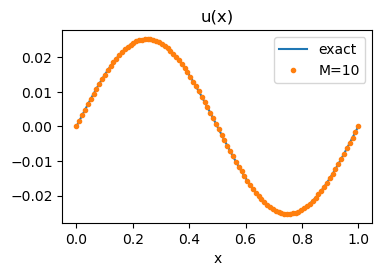

In [4]:
f = lambda x : np.sin(2*np.pi*x)

M = 10
plt.figure(figsize=(4,2.5))
plt.plot(x_list, np.sin(2*np.pi*x_list)/4/np.pi**2, label="exact")
y_list, _, _, _ = solve_variational(M, f, x_list)
plt.plot(x_list, y_list, '.', label="M={:d}".format(M))
plt.xlabel('x'); plt.title('u(x)'); plt.legend()
plt.show()

### Let us change $f$ to a slightly challenging one.

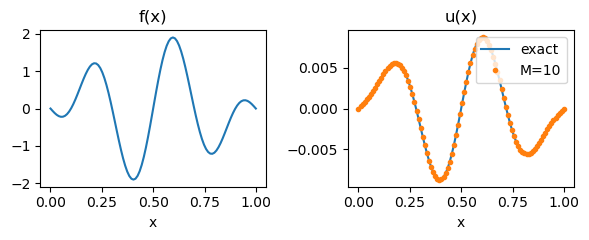

In [5]:
f = lambda x : np.sin(2*np.pi*2*x) - np.sin(2*np.pi*3*x)

plt.figure(figsize=(6,2.5))
plt.subplot(1,2,1)
plt.plot(x_list, f(x_list))
plt.xlabel('x'); plt.title('f(x)')

plt.subplot(1,2,2)
exact_u_values = np.array([exact_u(f, item) for item in x_list])
plt.plot(x_list, exact_u_values, label="exact")

M = 10; y_list, c, _, _ = solve_variational(M, f, x_list)
plt.plot(x_list, y_list, '.', label="M={:d}".format(M))
plt.xlabel('x'); plt.title('u(x)'); plt.legend(loc="upper right")

plt.tight_layout()

### Part 2: this example do not always work!

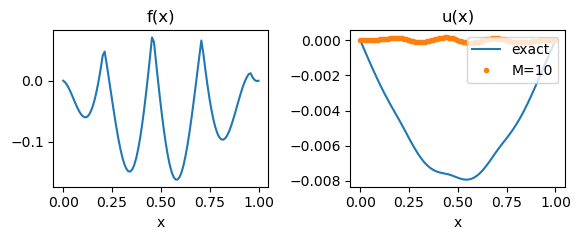

In [6]:
f = lambda x : x*(1-x)*(1/3 - np.abs(np.cos(2*np.pi*2*(x-1/3))))

plt.figure(figsize=(6,2.5))
plt.subplot(1,2,1)
plt.plot(x_list, f(x_list))
plt.xlabel('x'); plt.title('f(x)')

plt.subplot(1,2,2)
exact_u_values = np.array([exact_u(f, item) for item in x_list])
plt.plot(x_list, exact_u_values, label="exact")

M = 10; y_list, c, _, _ = solve_variational(M, f, x_list)
plt.plot(x_list, y_list, '.', label="M={:d}".format(M))
plt.xlabel('x'); plt.title('u(x)'); plt.legend(loc="upper right")

plt.tight_layout()

### Part 3: Let us try out piecewise linear functions with a basis function $\varphi$

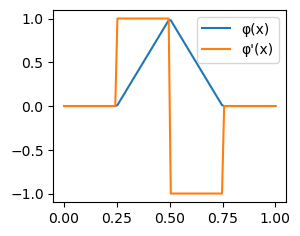

In [7]:
φ = lambda x : np.maximum(0, 1-np.abs(x))
φderi = lambda x : np.heaviside(1-np.abs(x),0) * (np.heaviside(x, 0.5)*(-2)+1)

x_list_tmp = np.linspace(-2, 2, 100)
plt.figure(figsize=(3,2.5))
plt.plot(x_list, φ(x_list_tmp), label="φ(x)")
plt.plot(x_list, φderi(x_list_tmp), label="φ'(x)")
plt.legend()
plt.show()

We consider 
$$V_M := \Big\{\phi(x) = \sum_{k=1}^{M-1} c_k \varphi\big(\frac{x-x_j}{h}\big)\Big\}$$
where $h = 1/M$ and $x_j=j/M$.

In [8]:
def ϕ_ln(h, shift):
    # basis functions
    return lambda x : φ((x-shift)/h)
    
def dϕ_ln(h, shift):
    # derivative of basis functions
    return lambda x : 1/h * φderi((x-shift)/h)

def solve_variational_linear(M, f):
    
    h = 1/M
    x_grid = np.array(np.arange(M+1)) * h
    ϕlist = [ϕ_ln(h, x_grid[j]) for j in range(1, M)]
    ϕderilist = [dϕ_ln(h, x_grid[j]) for j in range(1, M)]

    # Estimating A is NOT necessary in this case as A has a simpler expression.
    # we use integration in any case, simply to illustrate the framework.
    A = np.zeros((M-1,M-1))
    for j in range(M-1):
        for k in range(M-1):
            A[j,k] = scipy.integrate.quad(lambda x : (ϕderilist[j])(x)*(ϕderilist[k])(x), Lx, Rx)[0]

    b = np.zeros(M-1)
    for j in range(M-1):
        b[j] = scipy.integrate.quad(lambda x : (ϕlist[j])(x)*f(x), Lx, Rx)[0]

    c = np.linalg.solve(A, b)
    
    y_list = np.zeros(len(x_list))
    for j in range(len(x_list)):
        x = x_list[j]
        for k in range(M-1):
            y_list[j] += c[k] * (ϕlist[k])(x)

    return y_list, c, A, b

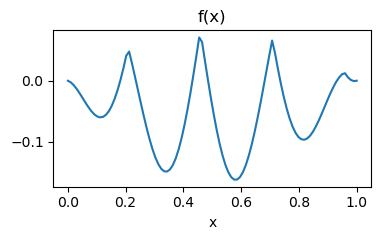

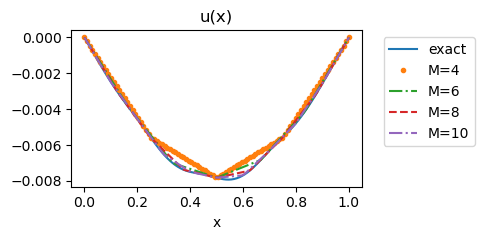

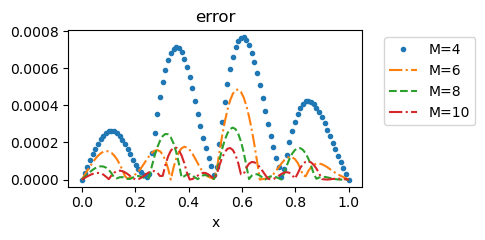

In [9]:
f = lambda x : x*(1-x)*(1/3 - np.abs(np.cos(2*np.pi*2*(x-1/3))))

plt.figure(figsize=(4,2.5))
plt.plot(x_list, f(x_list))
plt.title('f(x)'); plt.xlabel('x')
plt.tight_layout()

plt.figure(figsize=(5,2.5))

exact_u_values = np.array([exact_u(f, item) for item in x_list])
plt.plot(x_list, exact_u_values, label="exact")

M = 4; y_list, c, _, _ = solve_variational_linear(M, f)
plt.plot(x_list, y_list, '.', label="M={:d}".format(M))
M = 6; y_list, c, _, _ = solve_variational_linear(M, f)
plt.plot(x_list, y_list, '-.', label="M={:d}".format(M))
M = 8; y_list, c, A, _ = solve_variational_linear(M, f)
plt.plot(x_list, y_list, '--', label="M={:d}".format(M))
M = 10; y_list, c, A, _ = solve_variational_linear(M, f)
plt.plot(x_list, y_list, '-.', label="M={:d}".format(M))

plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title('u(x)'); plt.xlabel('x')
plt.tight_layout()

plt.figure(figsize=(5,2.5))

M = 4; y_list, c, _, _ = solve_variational_linear(M, f)
plt.plot(x_list, np.abs(y_list - exact_u_values), '.', label="M={:d}".format(M))
M = 6; y_list, c, _, _ = solve_variational_linear(M, f)
plt.plot(x_list, np.abs(y_list - exact_u_values), '-.', label="M={:d}".format(M))
M = 8; y_list, c, _, _ = solve_variational_linear(M, f)
plt.plot(x_list, np.abs(y_list - exact_u_values), '--', label="M={:d}".format(M))
M = 10; y_list, c, _, _ = solve_variational_linear(M, f)
plt.plot(x_list, np.abs(y_list - exact_u_values), '-.', label="M={:d}".format(M))

plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title('error'); plt.xlabel('x')
plt.tight_layout()

#### The matrix A has a certain pattern; see chp 6 later.

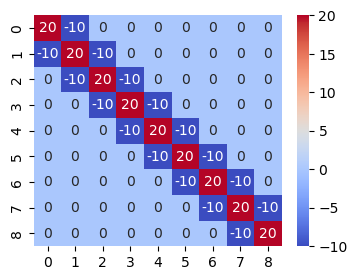

In [10]:
import seaborn as sns
fig = plt.figure(figsize=(4, 3))
sns.heatmap(A, annot=True, cmap='coolwarm')
plt.show()